In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm as tqdm
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [5]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000, 1, 28, 28)


In [7]:
def attack_image(xs, img):
    img = img.reshape(28, 28)
    imgs = []
    for i, x in enumerate(xs):
            y_pos, x_pos, intensity = x
            imgs.append(img.copy())
            imgs[i][y_pos][x_pos] = intensity

    return imgs

In [8]:
def predict_labels(images):
    dataset = TensorDataset(torch.from_numpy(np.array(images)).float(),
                            torch.from_numpy(np.array([-1]*len(images))).long()
                        )
    loader = DataLoader(dataset,
                          shuffle=True,
                          # pin_memory=True,
                          # num_workers=8,
                          drop_last=False,
                          batch_size=BATCH_SIZE)
    predictions = []
    for img, lbl in loader:
        out = model(img)
        predictions += torch.argmax(out, dim=1)
    return predictions

In [9]:
def attacked_predictions(image):
    image = image.reshape(28, 28)
    vec = []
    for y in range(0, 28):
        for x in range(0, 28):
            value = 255  # if image[y][x] < 128 else 0
            pix = [y, x, value]
            vec.append(pix)
    attacked_images = np.array(attack_image(vec, image))
    attacked_images = attacked_images.reshape(len(attacked_images), 1, 28, 28)
    predictions = np.array(predict_labels(attacked_images)).reshape(28, 28)
    return predictions

In [38]:
model = torch.load('mnistnet.pkl')

In [39]:
correct = 0
total_pictures = 0
for i, img in enumerate(X_test):
    preds = attacked_predictions(img)
    for y in range(28):
        for x in range(28):
            total_pictures+=1
            correct += preds[y][x] == y_test[i]

print("Accuracy: ", correct/total_pictures)

Accuracy:  0.9867934948979592


Функция изменения пикселя:

In [23]:
image_id = 0 # Image index in the test set
pixel = [[4, 4, 255], [7, 12, 255]] # pixel = x,y,value
print(attack_image(pixel, X_test[image_id].reshape(28,28))[0].shape)
image_perturbed = attack_image(pixel, X_test[image_id].reshape(28,28))

(28, 28)


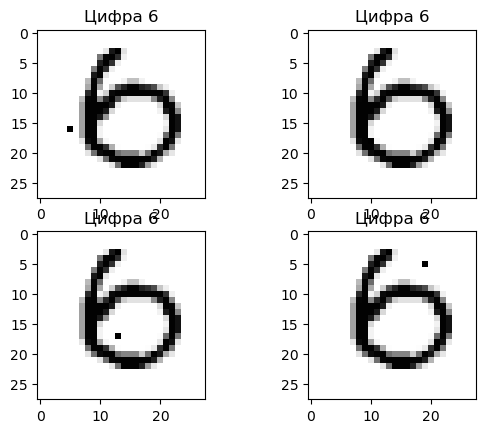

In [424]:
xs = [[16,  5, 255],
      [18, 10, 255],
      [17, 13, 255],
      [ 5, 19, 255]]
attacked_images = attack_image(xs, X_test[259])

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Цифра %d" % y_test[259])
    plt.imshow(attacked_images[i].reshape(28, 28), cmap='Greys')

In [277]:
# def evaluate_confidence(image, label):
#     image = image.reshape(28, 28)
#     vec = []
#     for y in range(0, 28):
#         for x in range(0, 28):
#             value = 255  # if image[y][x] < 128 else 0
#             pix = [y, x, value]
#             vec.append(pix)
#     attacked_images = np.array(attack_image(vec, image))
#     attacked_images = attacked_images.reshape(len(attacked_images), 1, 28, 28)
#     predictions = predict_labels(attacked_images)
#     # print(np.sum([pred == label for pred in predictions])/len(predictions)*100, '%')
#     plt.figure(figsize=(20, 20))
#     # for i in range(20):
#     #     plt.subplot(4, 5, i+1)
#     #     plt.title(predictions[i])
#     #     plt.imshow(attacked_images[i].reshape(28, 28), cmap='Greys')
#     return np.sum([pred == label for pred in predictions])/len(predictions)

In [398]:
pixel_width = []
for y in range(28):
    pixel_width.append([])
    for x in range(28):
        lcl_min = 256
        lcl_max = -1
        for img in X.reshape(X.shape[0], 28, 28):
            lcl_min = min(lcl_min, img[y][x])
            lcl_max = max(lcl_max, img[y][x])
            if lcl_min == 0 and lcl_max == 255:
                break
        pixel_width[y].append(lcl_max - lcl_min)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 116.0, 254.0, 216.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 16.0, 47.0, 236.0, 254.0, 255.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 244.0, 255.0, 184.0, 197.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 64.0, 29.0, 134.0, 192.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 165.0, 0.0, 0.0]
[0.0, 0.0, 141.0, 101.0, 139.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 234.0, 163.0, 0.0]
[0.0, 38.0, 144.0, 114.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 246.0, 63.0]
[0.0, 24.0, 95.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 2

In [399]:
for y in range(28):
    print(pixel_width[y])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 116.0, 254.0, 216.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 16.0, 47.0, 236.0, 254.0, 255.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 244.0, 255.0, 184.0, 197.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 64.0, 29.0, 134.0, 192.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 165.0, 0.0, 0.0]
[0.0, 0.0, 141.0, 101.0, 139.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 234.0, 163.0, 0.0]
[0.0, 38.0, 144.0, 114.0, 254.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 246.0, 63.0]
[0.0, 24.0, 95.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 2

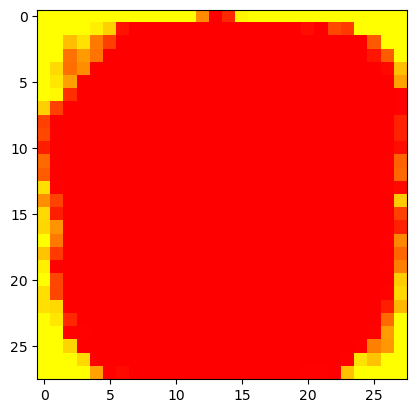

In [606]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_width, cmap = "autumn_r")

In [396]:
pixel_width.sort(reverse=True)
pixel_width

[[226.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  254.0,
  243.0],
 [191.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  254.0,
  221.0],
 [184.0,
  254.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  220.0],
 [163.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  252.0

In [12]:
correct = 0
total_pictures = 0
for i, img in enumerate(X_test):
    preds = attacked_predictions(img)
    for y in range(28):
        for x in range(28):
            total_pictures+=1
            correct += preds[y][x] == y_test[i]

print("Accuracy: ", correct/total_pictures)

Accuracy:  0.98544225


In [549]:
pixel_vulnerability = []
for y in range(0, 20):
    pixel_vulnerability.append([])
    for x in range(0, 20):
        pixel_vulnerability[y].append(0)

In [550]:
for i, img in enumerate(X_test):
    preds = attacked_predictions(img)
    for y in range(20):
        for x in range(20):
            pixel_vulnerability[y][x] += preds[y][x] != y_test[i]

In [552]:
print(pixel_vulnerability)
relative_pixel_vulnerability = np.divide(pixel_vulnerability, 1200)
print(relative_pixel_vulnerability)

[[136, 136, 139, 134, 135, 138, 136, 137, 136, 137, 129, 134, 134, 130, 136, 134, 134, 141, 137, 143], [123, 133, 133, 132, 134, 139, 136, 132, 133, 132, 133, 133, 130, 136, 134, 127, 130, 139, 133, 126], [131, 135, 136, 127, 136, 136, 137, 138, 138, 137, 134, 130, 130, 138, 140, 138, 129, 137, 136, 140], [150, 131, 137, 134, 133, 125, 141, 131, 142, 134, 132, 135, 132, 136, 134, 127, 133, 134, 138, 140], [139, 133, 131, 138, 138, 137, 126, 136, 134, 136, 135, 140, 140, 133, 137, 139, 136, 134, 143, 141], [138, 136, 134, 133, 138, 130, 140, 132, 132, 130, 139, 134, 133, 133, 138, 132, 136, 130, 141, 138], [144, 139, 132, 136, 132, 141, 135, 136, 134, 135, 129, 134, 140, 137, 134, 132, 138, 141, 144, 136], [137, 133, 137, 130, 137, 131, 137, 137, 138, 138, 134, 135, 135, 133, 131, 134, 130, 127, 130, 139], [134, 138, 136, 135, 134, 137, 134, 137, 134, 132, 134, 136, 135, 129, 136, 141, 133, 138, 134, 137], [141, 134, 131, 139, 136, 151, 140, 134, 139, 137, 137, 135, 135, 130, 130, 132, 

In [571]:
print(relative_pixel_vulnerability[3][0])

0.125


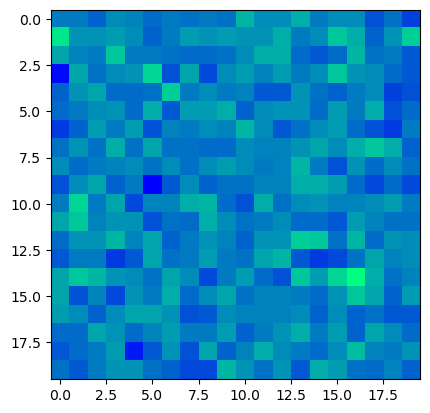

In [551]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_vulnerability, cmap='winter_r')

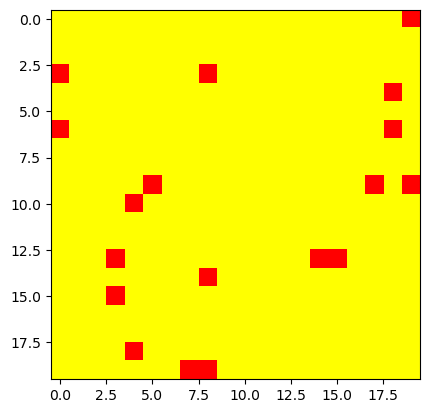

In [595]:
interest_pixels = [1 if percent >= 0.118 else 0 for percent in np.array(relative_pixel_vulnerability).reshape(400)]
interest_pixels = np.array(interest_pixels).reshape(20, 20)
fig, ax = plt.subplots()
im = ax.imshow(interest_pixels, cmap='autumn_r')

In [596]:
interest_pixels_lst = []
for row in range(0, 20):
    for col in range(0, 20):
        if interest_pixels[row][col] == 1:
            interest_pixels_lst.append([row+5, col+5])

In [597]:
interest_pixels_lst

[[5, 24],
 [8, 5],
 [8, 13],
 [9, 23],
 [11, 5],
 [11, 23],
 [14, 10],
 [14, 22],
 [14, 24],
 [15, 9],
 [18, 8],
 [18, 19],
 [18, 20],
 [19, 13],
 [20, 8],
 [23, 9],
 [24, 12],
 [24, 13]]

Атака модели, обученной на пиксельной атаке

In [ ]:
with open("attack_pixels.txt", "w") as file:
    print(*interest_pixels_lst, file=file, sep="\n")

In [10]:
model = torch.load('mnistnet_pixel1.pkl')

In [11]:
correct = 0
total_pictures = 0
for i, img in enumerate(X_test):
    preds = attacked_predictions(img)
    for y in range(28):
        for x in range(28):
            total_pictures+=1
            correct += preds[y][x] == y_test[i]

print("Accuracy: ", correct/total_pictures * 100, "%")

Accuracy:  99.10316326530612 %


In [11]:
pixel_vulnerability = []
for y in range(0, 20):
    pixel_vulnerability.append([])
    for x in range(0, 20):
        pixel_vulnerability[y].append(0)

In [12]:
for i, img in enumerate(X_test):
    preds = attacked_predictions(img)
    for y in range(20):
        for x in range(20):
            pixel_vulnerability[y][x] += preds[y][x] != y_test[i]

In [13]:
print(pixel_vulnerability)
relative_pixel_vulnerability = np.divide(pixel_vulnerability, 1200)
print(relative_pixel_vulnerability)

[[91, 88, 91, 86, 91, 91, 94, 91, 90, 90, 90, 88, 90, 89, 92, 89, 90, 89, 87, 87], [90, 93, 96, 89, 88, 90, 86, 86, 93, 85, 88, 83, 86, 89, 87, 91, 88, 86, 92, 89], [95, 93, 92, 90, 89, 85, 88, 89, 91, 91, 90, 91, 86, 88, 90, 91, 89, 87, 92, 89], [88, 87, 91, 89, 91, 89, 92, 90, 94, 93, 91, 87, 90, 91, 89, 90, 94, 92, 89, 88], [86, 90, 89, 90, 91, 92, 87, 94, 89, 91, 89, 91, 89, 96, 89, 89, 90, 89, 89, 92], [84, 87, 91, 89, 89, 88, 91, 91, 91, 89, 90, 85, 85, 94, 90, 86, 91, 91, 89, 86], [91, 88, 91, 91, 92, 88, 91, 93, 91, 86, 89, 87, 89, 92, 87, 92, 87, 92, 88, 90], [91, 89, 91, 87, 93, 92, 88, 85, 92, 88, 92, 85, 89, 91, 92, 90, 86, 89, 85, 88], [91, 92, 85, 88, 89, 87, 89, 91, 89, 93, 86, 88, 88, 88, 94, 90, 86, 91, 85, 88], [88, 92, 87, 92, 87, 88, 90, 89, 92, 92, 84, 89, 88, 91, 89, 92, 89, 90, 82, 91], [90, 97, 86, 88, 85, 89, 91, 93, 90, 87, 83, 89, 91, 86, 89, 88, 86, 87, 86, 92], [94, 90, 88, 90, 87, 89, 89, 89, 93, 86, 92, 90, 91, 88, 94, 93, 90, 92, 92, 91], [91, 88, 93, 87

In [14]:
print(np.max(relative_pixel_vulnerability), np.min(relative_pixel_vulnerability))

0.08083333333333333 0.06833333333333333


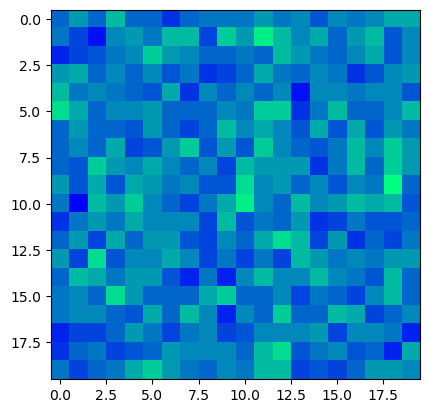

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_vulnerability, cmap='winter_r')